In [61]:
import numpy as np
import pandas as pd
import seaborn as sns
from termcolor import colored
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from wordcloud import WordCloud

# ignore sns and matplotlib warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
from sklearn.preprocessing import (
    StandardScaler, 
    MinMaxScaler, 
    RobustScaler, 
    Normalizer, 
    QuantileTransformer, 
    PowerTransformer,
    FunctionTransformer,
    LabelEncoder, 
    OneHotEncoder, 
    OrdinalEncoder,
)

from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.impute import MissingIndicator

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn_pandas import DataFrameMapper, gen_features

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin;

In [4]:
raw_train = pd.read_csv('data/training.csv')
raw_test = pd.read_csv('data/test.csv')

X, y = raw_train.drop(columns=['DiagPeriodL90D']), raw_train['DiagPeriodL90D']

In [83]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

## **Null Exploration**

<Axes: >

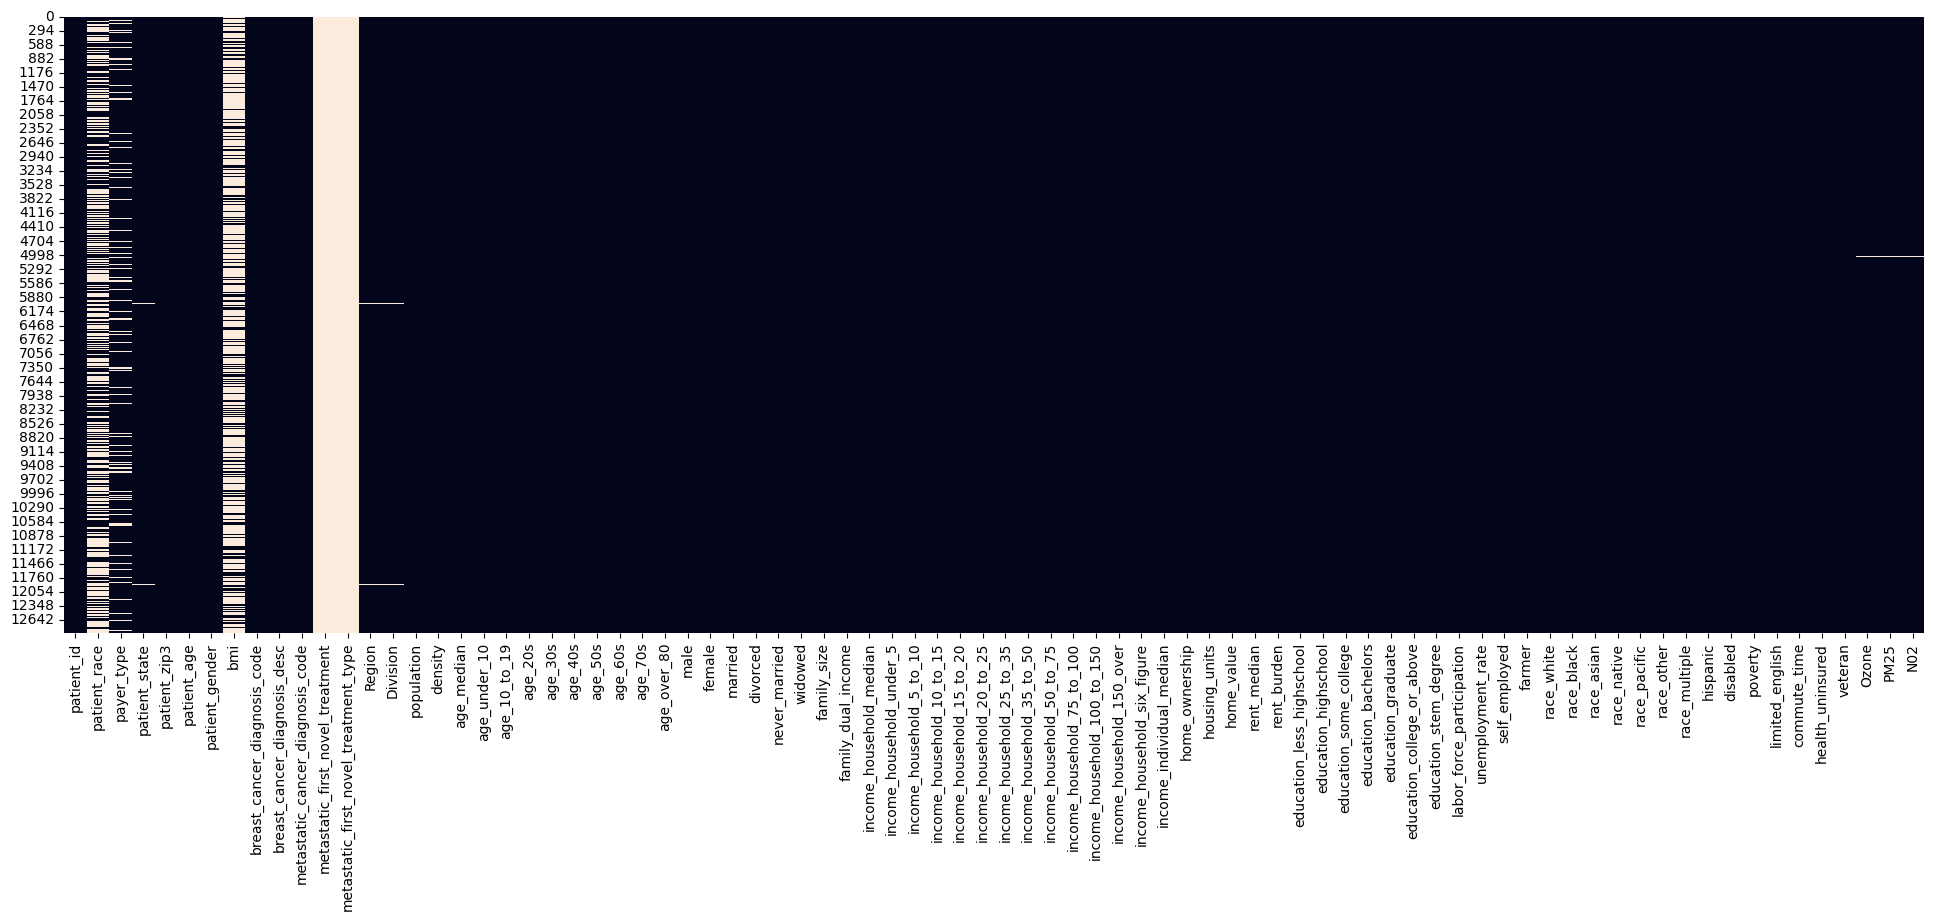

In [143]:
_, ax = plt.subplots(1, 1, figsize=(24, 8))
sns.heatmap(X.isnull(), cbar=False, ax=ax)

In [39]:
# Every column with at least 10% of missing values in Train dataset
print(colored('Trainset columns with > 10% missing values\n', 'red', attrs=['bold']))

missing = X.isnull().sum()
_10_percent = X.shape[0] * 0.1
missing = missing[missing > _10_percent].sort_values(ascending=False)
print(missing)

Trainset columns with > 10% missing values

metastatic_first_novel_treatment         12882
metastatic_first_novel_treatment_type    12882
bmi                                       8965
patient_race                              6385
payer_type                                1803
dtype: int64


<Axes: >

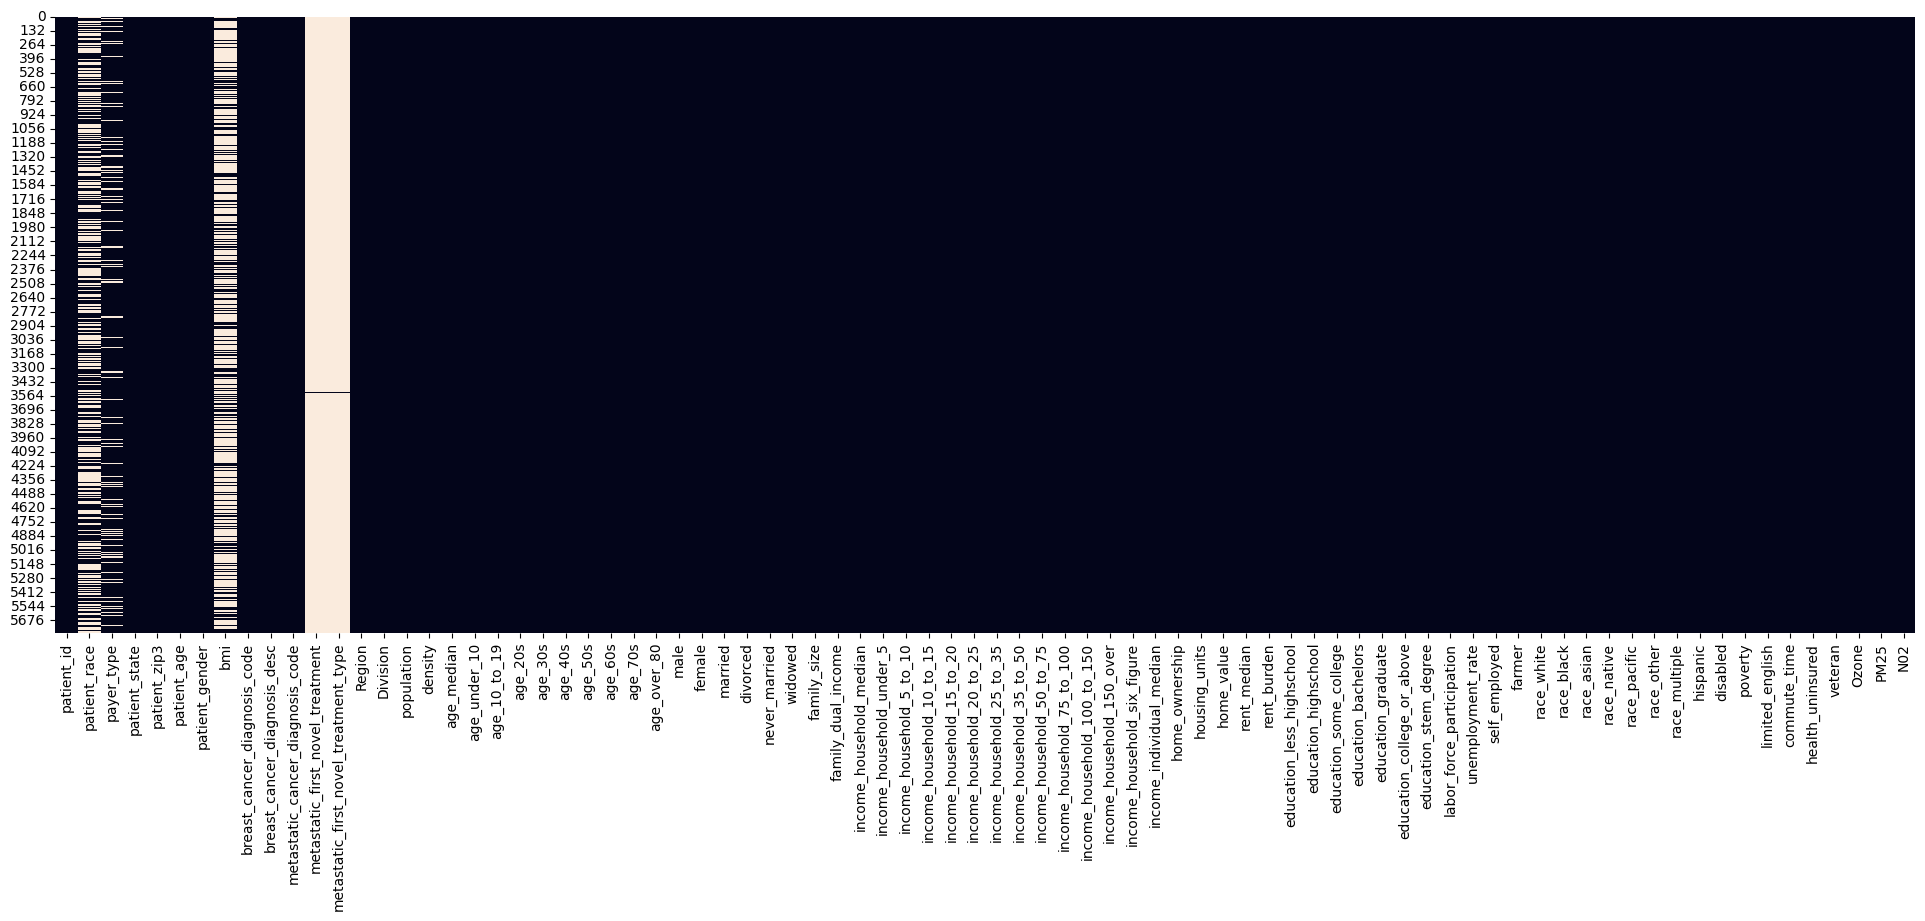

In [144]:
_, ax = plt.subplots(1, 1, figsize=(24, 8))
sns.heatmap(raw_test.isnull(), cbar=False, ax=ax)

In [40]:
# Every column with at least 10% of missing values in Train dataset
print(colored('Testset columns with > 10% missing values\n', 'red', attrs=['bold']))

missing = raw_test.isnull().sum()
_10_percent = raw_test.shape[0] * 0.1
missing = missing[missing > _10_percent].sort_values(ascending=False)
print(missing)

Testset columns with > 10% missing values

metastatic_first_novel_treatment         5781
metastatic_first_novel_treatment_type    5781
bmi                                      4015
patient_race                             2901
payer_type                                760
dtype: int64


## **Patient**

In [5]:
X_Patient = X.iloc[:,:15]
X_Patient = X_Patient.drop(columns=['metastatic_first_novel_treatment', 'metastatic_first_novel_treatment_type'])
X_Patient.payer_type = X_Patient.payer_type.apply(lambda x: x.lower() if type(x) == str else x)


print(colored(f'There are {X_Patient.shape[1]} patient columns\n', color='blue'))

s = ''
for i in range(X_Patient.shape[1]):
    col = X_Patient.columns[i]
    if i != 0 and i % 4 == 0:
        s = f'{s}{col}\n'
    else:
        s = f'{s}{col},  '

print(f'{s}\n')

print(colored('\nPatient features description', color='blue'))
display(X_Patient.drop('patient_id', axis=1).describe().round(2))

print(colored('\nPatient features types', color='blue'))
display(X_Patient.dtypes.sort_values())

print(colored('\nPatient features unique values', color='blue'))
for col in X_Patient.select_dtypes(exclude='number').columns:
    print(f'{col}: {X_Patient[col].nunique()}')

There are 13 patient columns

patient_id,  patient_race,  payer_type,  patient_state,  patient_zip3
patient_age,  patient_gender,  bmi,  breast_cancer_diagnosis_code
breast_cancer_diagnosis_desc,  metastatic_cancer_diagnosis_code,  Region,  Division



Patient features description


patient_zip3  patient_age      bmi
count      12906.00     12906.00  3941.00
mean         573.75        59.18    28.98
std          275.45        13.34     5.70
min          101.00        18.00    14.00
25%          331.00        50.00    24.66
50%          554.00        59.00    28.19
75%          846.00        67.00    32.92
max          999.00        91.00    85.00


Patient features types


patient_id                            int64
patient_zip3                          int64
patient_age                           int64
bmi                                 float64
patient_race                         object
payer_type                           object
patient_state                        object
patient_gender                       object
breast_cancer_diagnosis_code         object
breast_cancer_diagnosis_desc         object
metastatic_cancer_diagnosis_code     object
Region                               object
Division                             object
dtype: object


Patient features unique values
patient_race: 5
payer_type: 3
patient_state: 50
patient_gender: 1
breast_cancer_diagnosis_code: 50
breast_cancer_diagnosis_desc: 50
metastatic_cancer_diagnosis_code: 43
Region: 4
Division: 9


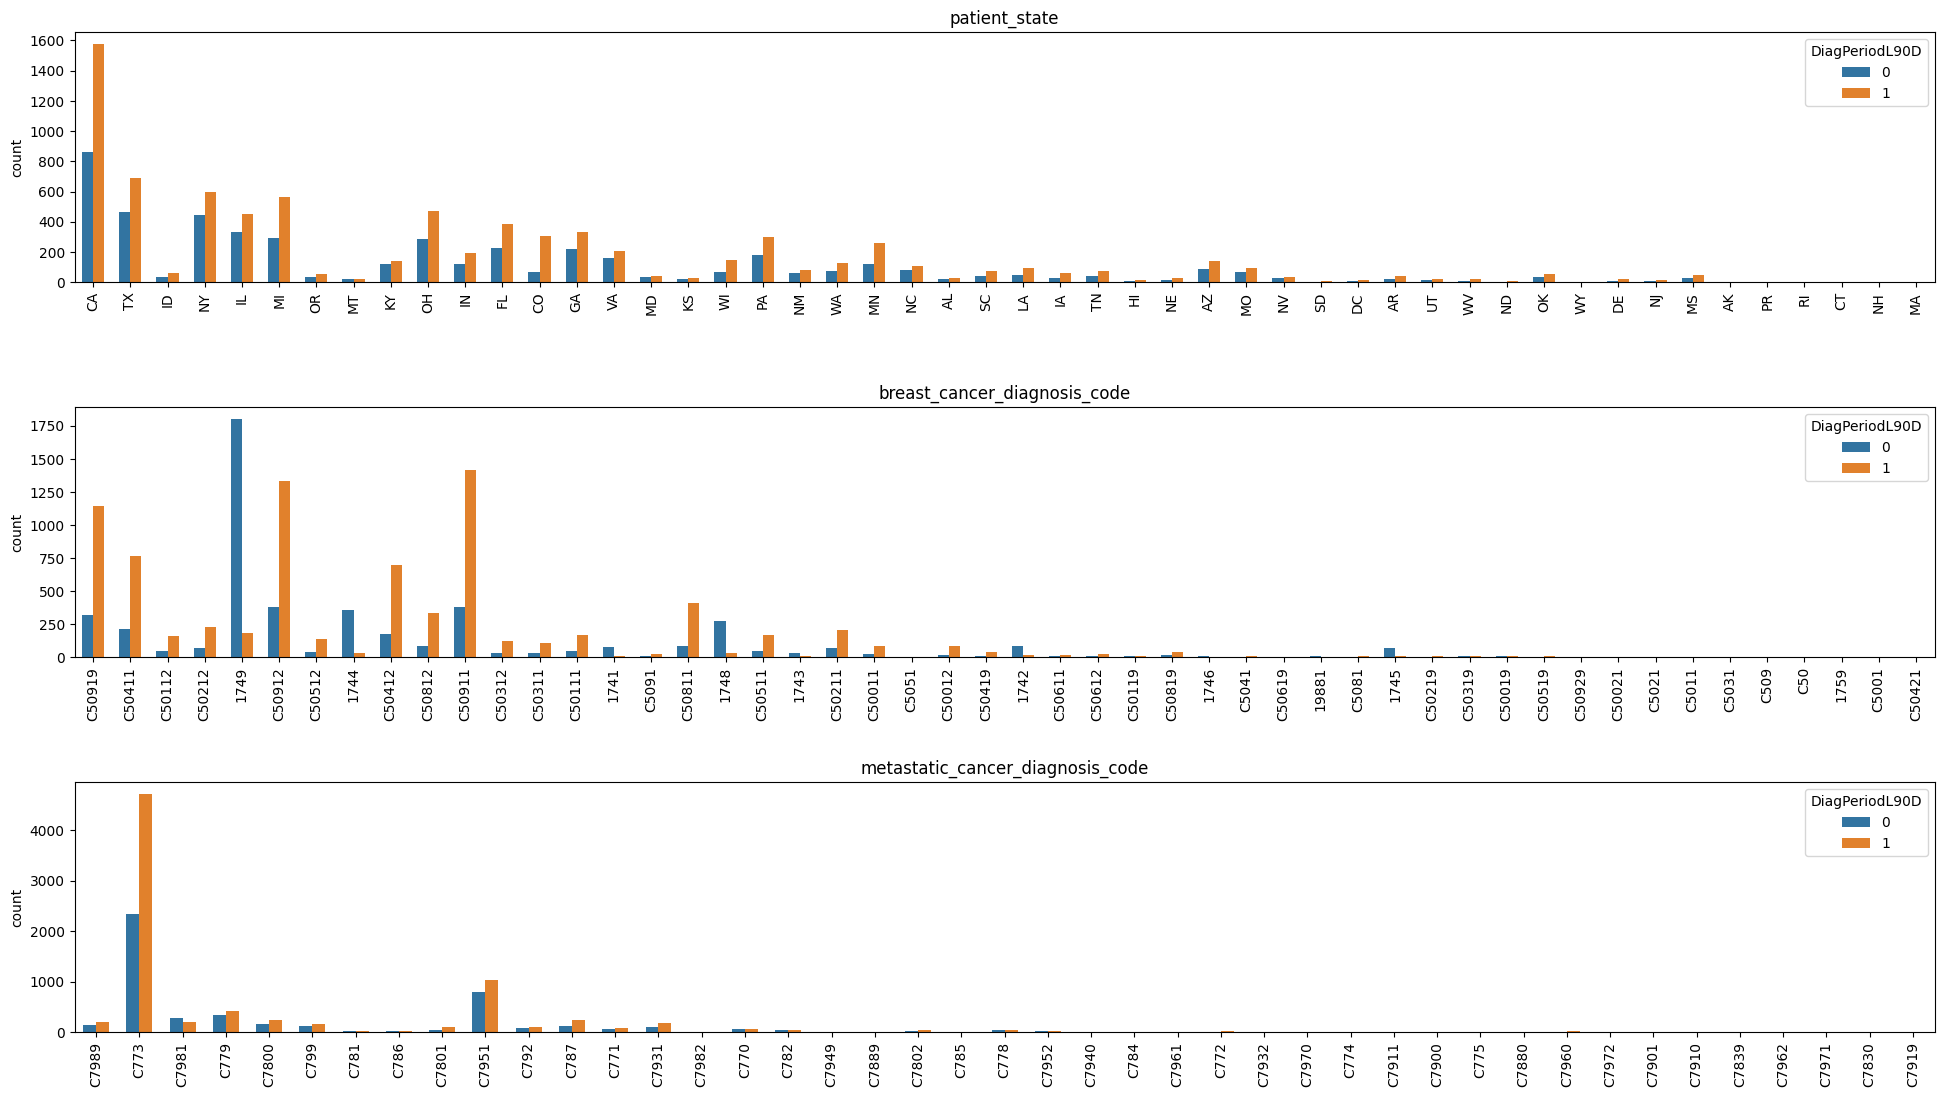

In [142]:
cols = ['patient_state', 'breast_cancer_diagnosis_code', 'metastatic_cancer_diagnosis_code']
X_Patient['DiagPeriodL90D'] = y

fig, axes = plt.subplots(3, 1, figsize=(24, 5))
plt.subplots_adjust(bottom=3, top=5, hspace=0.5)
axes = axes.ravel()

# _ = X_Patient.groupby(['breast_cancer_diagnosis_code','DiagPeriodL90D']).agg({'patient_id':'count'})
# display(_['patient_id'])

# log_transform = FunctionTransformer(np.log1p, validate=True)
# log_transform.fit_transform(X_Patient['patient_age'].values.reshape(-1, 1))

# sns.barplot(data=_ , x='patient_id', width=0.6, ax=axes[i])

for i, col in enumerate(cols):
    sns.countplot(data=X_Patient , x=col, hue='DiagPeriodL90D', width=0.6, ax=axes[i])
    axes[i].xaxis.set_tick_params(rotation=90)
    axes[i].set_xlabel('')
    axes[i].set_title(col)


In [86]:
print(colored('Confirming that metastatic and breast cancer diagnosis codes are not leaking\n', color='blue', attrs=['bold']))
print(f'Number of specific metast. diagnosis codes: {X_Patient.metastatic_cancer_diagnosis_code.nunique()}')
print(f'Number of combinations metast. diagnosis & target: {X_Patient.groupby(["metastatic_cancer_diagnosis_code", "DiagPeriodL90D"]).agg({"patient_id": "count"}).shape[0]}\n')
print(f'Number of specific breast diagnosis codes: {X_Patient.breast_cancer_diagnosis_code.nunique()}')
print(f'Number of combinations breast diagnosis & target: {X_Patient.groupby(["breast_cancer_diagnosis_code", "DiagPeriodL90D"]).agg({"patient_id": "count"}).shape[0]}')

Confirming that metastatic and breast cancer diagnosis codes are not leaking

Number of specific metast. diagnosis codes: 43
Number of combinations metast. diagnosis & target: 75

Number of specific breast diagnosis codes: 50
Number of combinations breast diagnosis & target: 89


### **Mapping ICD-9 codes to ICD-10 and mapping male related to female related codes**

Conversions were made based on this [ICD-10 manual](https://www.icd10data.com/ICD10CM/Codes/C00-D49/C50-C50/C50-), and the ICD-9 conversor, that was accessed through the [Wikipedia page](https://en.wikipedia.org/wiki/List_of_ICD-9_codes_140%E2%80%93239:_neoplasms). The matching was performed over the breast cancer description ( which is being displayed in the cell below ).

1741 -> C50119 <br>
1742 -> C50219 <br>
1743 -> C50319 <br>
1744 -> C50419 <br>
1745 -> C50519 <br>
1746 -> C50619 <br>
1748 -> C50819 <br>
1749 -> C50919 <br><br>

**Male to Female** <br>

1759 -> C50919 <br>
C50929 -> C50919 <br>
C50421 -> C50411 <br>
C50021 -> C50011

In [100]:
# This Data Frame has 50 lines

X_Patient \
    .groupby(['breast_cancer_diagnosis_desc', 'breast_cancer_diagnosis_code']) \
    .agg({'patient_id':'count'}) \
    .sort_values(by='patient_id', ascending=False) \
    .head(10) # CHANGE TO 50 TO SEE ALL

patient_id
breast_cancer_diagnosis_desc                       breast_cancer_diagnosis_code            
Malignant neoplasm of breast (female), unspecified 1749                                1982
Malignant neoplasm of unsp site of right female... C50911                              1797
Malignant neoplasm of unspecified site of left ... C50912                              1712
Malignant neoplasm of unsp site of unspecified ... C50919                              1467
Malig neoplm of upper-outer quadrant of right f... C50411                               978
Malig neoplasm of upper-outer quadrant of left ... C50412                               877
Malignant neoplasm of ovrlp sites of right fema... C50811                               491
Malignant neoplasm of ovrlp sites of left femal... C50812                               419
Malignant neoplasm of upper-outer quadrant of f... 1744                                 389
Malignant neoplasm of other specified sites of ... 1748                                 307

In [101]:
unique_desc  = X_Patient.breast_cancer_diagnosis_desc.unique()
unique_count = X_Patient.breast_cancer_diagnosis_desc.value_counts()
print(colored(f'Number of unique breast cancer diagnosis descriptions: {len(unique_desc)}', color='blue', attrs=['bold']))

range_of_sight = 25 # CHANGE TO 50 TO SEE ALL
print(colored(f'\nHalf ({range_of_sight}) of the breast cancer diagnosis descriptions, ordered by frequency:', color='blue'))
display(unique_count[:range_of_sight])

print(colored(f'Descriptions about male patients (Anomalies):', color='red', attrs=['bold']))
for desc in unique_desc:
    if ' male' in desc:
        print(f'Appearences: {unique_count[desc]} -> {desc}')

Number of unique breast cancer diagnosis descriptions: 50

Half (25) of the breast cancer diagnosis descriptions, ordered by frequency:


breast_cancer_diagnosis_desc
Malignant neoplasm of breast (female), unspecified              1982
Malignant neoplasm of unsp site of right female breast          1797
Malignant neoplasm of unspecified site of left female breast    1712
Malignant neoplasm of unsp site of unspecified female breast    1467
Malig neoplm of upper-outer quadrant of right female breast      978
Malig neoplasm of upper-outer quadrant of left female breast     877
Malignant neoplasm of ovrlp sites of right female breast         491
Malignant neoplasm of ovrlp sites of left female breast          419
Malignant neoplasm of upper-outer quadrant of female breast      389
Malignant neoplasm of other specified sites of female breast     307
Malig neoplasm of upper-inner quadrant of left female breast     293
Malig neoplm of upper-inner quadrant of right female breast      276
Malig neoplm of lower-outer quadrant of right female breast      213
Malignant neoplasm of central portion of left female breast      209
Malig

Descriptions about male patients (Anomalies):
Appearences: 3 -> Malignant neoplasm of unsp site of unspecified male breast
Appearences: 1 -> Malignant neoplasm of nipple and areola, right male breast
Appearences: 1 -> Malignant neoplasm of other and unspecified sites of male breast
Appearences: 1 -> Malig neoplasm of upper-outer quadrant of right male breast


(-0.5, 799.5, 399.5, -0.5)

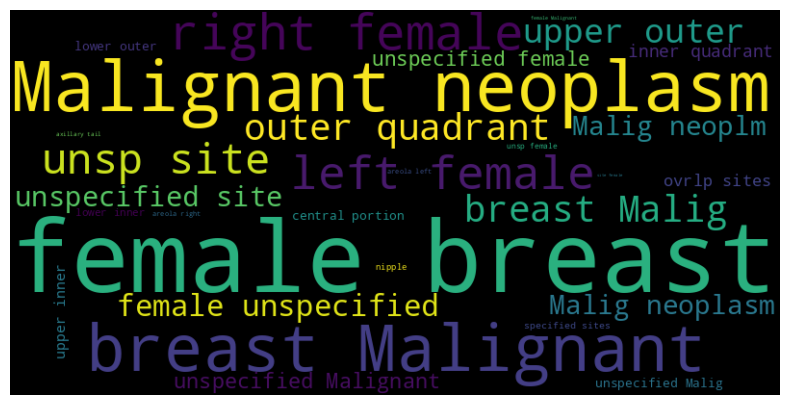

In [223]:
# Since there are +16,000 entries in Training Data, and about 50 unique descriptions, 
# this wordcloud is a good deescriptor of the Test Data as well

wordcloud = WordCloud(
    width=800,
    height=400,
    random_state=21,
    max_font_size=110,
    background_color='black'
).generate(' '.join(X_Patient.breast_cancer_diagnosis_desc.dropna().values))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

## **Target Exploration for Patient**

Text(0.5, 1.0, 'Target balance')

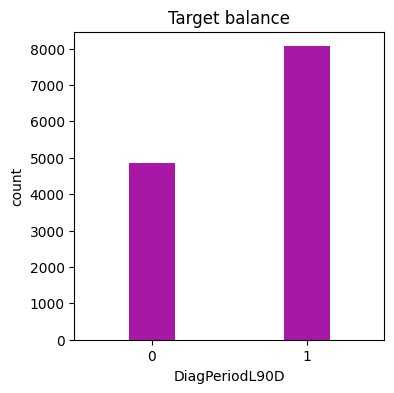

In [36]:
# Plot value counts for DiagPeriodL90D
_, ax = plt.subplots(1, 1, figsize=(4, 4))
sns.barplot(x=y.value_counts().index, y=y.value_counts(), width=0.3, ax=ax, color='m')
ax.set_title('Target balance')

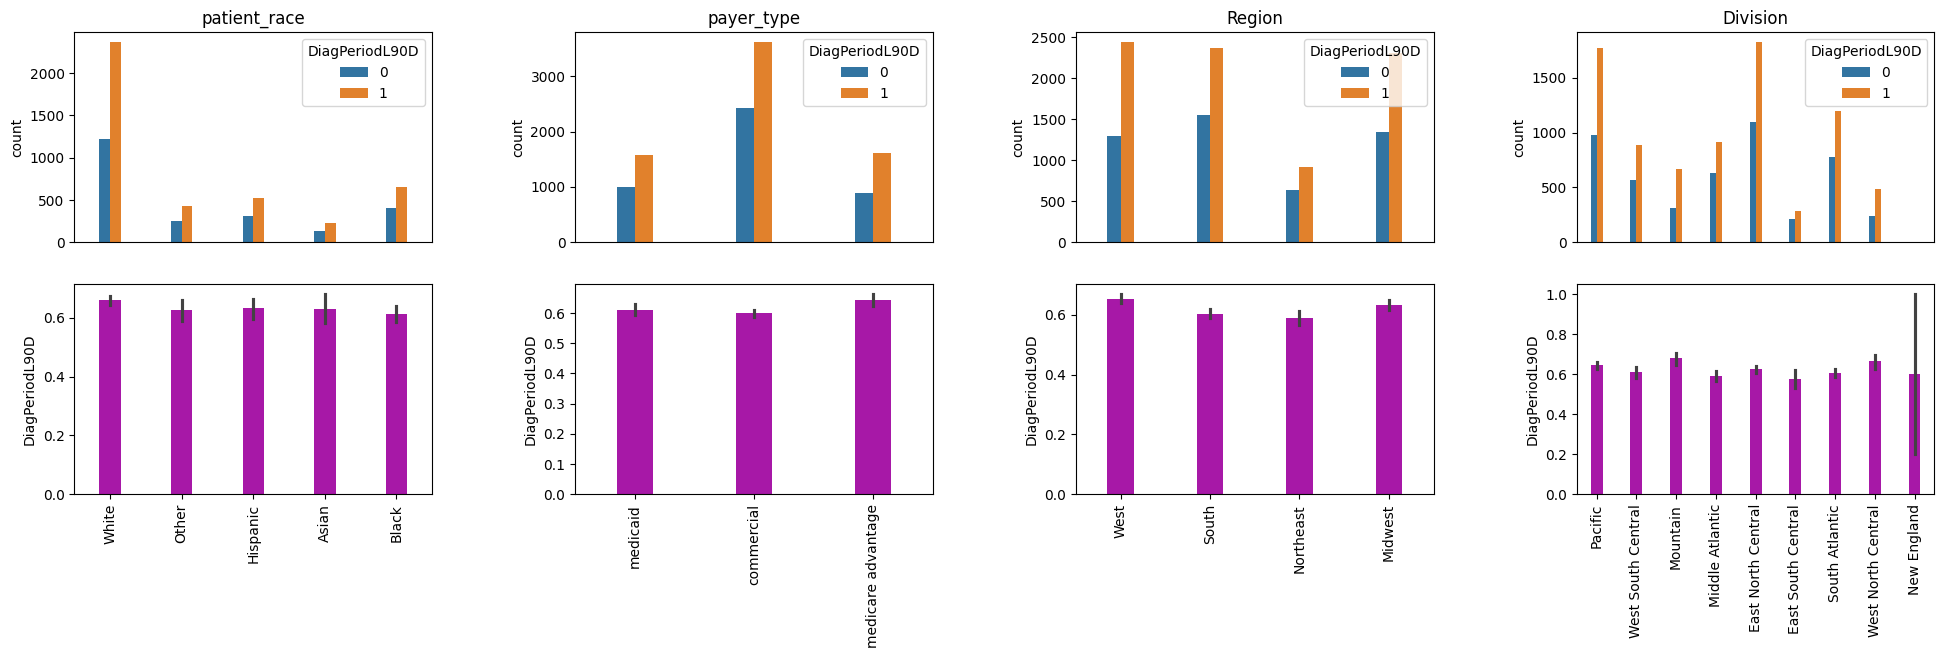

In [141]:
# plot X_Patient features realationship with the target
_, axes = plt.subplots(2, 4, figsize=(24, 6))
plt.subplots_adjust(wspace=0.4)
axes = axes.ravel()

X_Patient['DiagPeriodL90D'] = y

cols = ['patient_race', 'payer_type', 'Region', 'Division']
for i, col in enumerate(cols):
    sns.countplot(x=col, hue='DiagPeriodL90D', data=X_Patient, ax=axes[i], width=0.3)
    axes[i].set_title(col)
    axes[i].xaxis.set_ticks([])
    axes[i].set_xlabel('')

for i, col in enumerate(cols):
    j = i + 4
    sns.barplot(x=col, y='DiagPeriodL90D', data=X_Patient, ax=axes[j], width=0.3, color='m')
    axes[j].xaxis.set_tick_params(rotation=90)
    axes[j].set_xlabel('')

### **Inference of BMI**

Is well known that BMI in the United States is strongly correlated to [income and scholarity](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2709073/). This phenomena will be further used to infer the most probable BMI for each pacient with non existing. For such task we need four indicators: Income, Location, Race, and Age.

* Income will be measured by `payer_type`, `income features`
* Location is pointed by `patient_state`
* Race is pointed by `patient_race`
* Age is pointed by `patient_age`

An extra column `bmi_infered` will be created, where every value is either 0, for not infered, or 1 for infered.

<Axes: xlabel='payer_type', ylabel='bmi'>

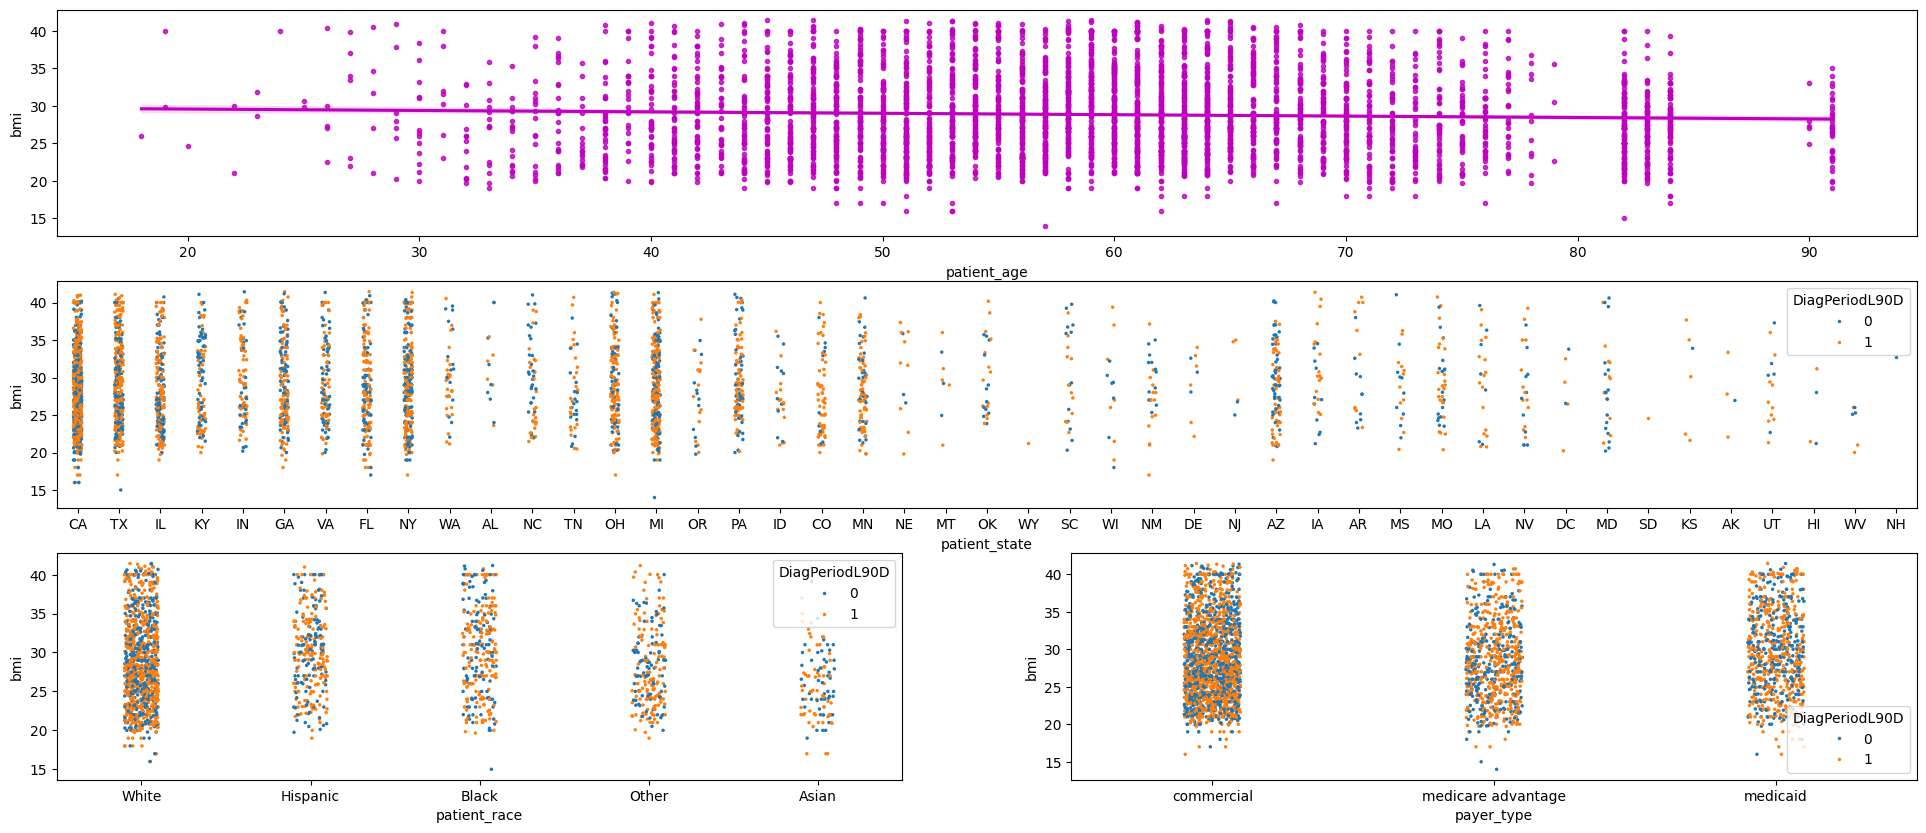

In [140]:
fig_shape = (3, 2)

fig = plt.figure(figsize=(24, 10))
ax1 = plt.subplot2grid(fig_shape, (0, 0), colspan=3)
ax2 = plt.subplot2grid(fig_shape, (1, 0), colspan=3)
ax3 = plt.subplot2grid(fig_shape, (2, 0), colspan=1)
ax4 = plt.subplot2grid(fig_shape, (2, 1), colspan=1)

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlabel('')

# _ is a copy of X_Patient with 1% of outliers removed
q = X_Patient.bmi.quantile(0.99)
_ = X_Patient.copy()
_ = _[_['bmi'] < q]

sns.regplot(x='patient_age', y='bmi', data=_, color='m', marker='.', ax=ax1)
sns.stripplot(x='patient_state', y='bmi', data=_, marker='.', hue='DiagPeriodL90D', ax=ax2)
sns.stripplot(x='patient_race', y='bmi', data=_, marker='.', hue='DiagPeriodL90D', ax=ax3)
sns.stripplot(x='payer_type', y='bmi', data=_, marker='.', hue='DiagPeriodL90D', ax=ax4)


### **Desired Patient characteristics for ML:**

to decide -> Region,  Division

derived from **'patient_state'**:
* 1 State
* 2 Link to Demographic conditions

**Will be present :** payer_type , patient_zip3 , patient_race , patient_age , breast_cancer_diagnosis_code , metastatic_cancer_diagnosis_code , bmi

**Derived from :** breast_cancer_diagnosis_desc:
* 1 Presence of 'Malignant' or 'Malig'
* 2 Presence of 'Unspecified' or 'unsp'
* 3 Indication of side 'Right' or 'Left'


## **Demographics**

In [145]:
X_Demographic = X.iloc[:,15:]
X_Demographic['patient_id'] = X_Patient.patient_id

print(colored(f'There are {X_Demographic.shape[1]} demographic columns\n', color='blue'))

s = ''
for i in range(X_Demographic.shape[1]):
    col = X_Demographic.columns[i]
    if i != 0 and i % 4 == 0:
        s = f'{s}{col}\n'
    else:
        s = f'{s}{col},  '

print(f'{s}\n')

There are 68 demographic columns

population,  density,  age_median,  age_under_10,  age_10_to_19
age_20s,  age_30s,  age_40s,  age_50s
age_60s,  age_70s,  age_over_80,  male
female,  married,  divorced,  never_married
widowed,  family_size,  family_dual_income,  income_household_median
income_household_under_5,  income_household_5_to_10,  income_household_10_to_15,  income_household_15_to_20
income_household_20_to_25,  income_household_25_to_35,  income_household_35_to_50,  income_household_50_to_75
income_household_75_to_100,  income_household_100_to_150,  income_household_150_over,  income_household_six_figure
income_individual_median,  home_ownership,  housing_units,  home_value
rent_median,  rent_burden,  education_less_highschool,  education_highschool
education_some_college,  education_bachelors,  education_graduate,  education_college_or_above
education_stem_degree,  labor_force_participation,  unemployment_rate,  self_employed
farmer,  race_white,  race_black,  race_asian
race

In [162]:
def plot_demographic_features(data_frame, vec, rows, cols, figsize, hspace=1):
    _, axes = plt.subplots(rows, cols, figsize=figsize)
    plt.subplots_adjust(hspace=hspace)
    axes = axes.ravel()

    for i, col in enumerate(vec):
        sns.histplot(data_frame[col], color='m', ax=axes[i], kde=True)
        title = \
            f'{col}\n' \
            f'skew: {data_frame[col].skew():.1f}\n' \
            f'kurtosis: {data_frame[col].kurtosis():.1f}\n' \
            f'mode: {data_frame[col].mode().values[0]}\n' \
            f'mean: {data_frame[col].mean():.1f}\n' \
            f'median: {data_frame[col].median():.1f}'
        axes[i].set_title(title, color='g')
        axes[i].set_xlabel('')

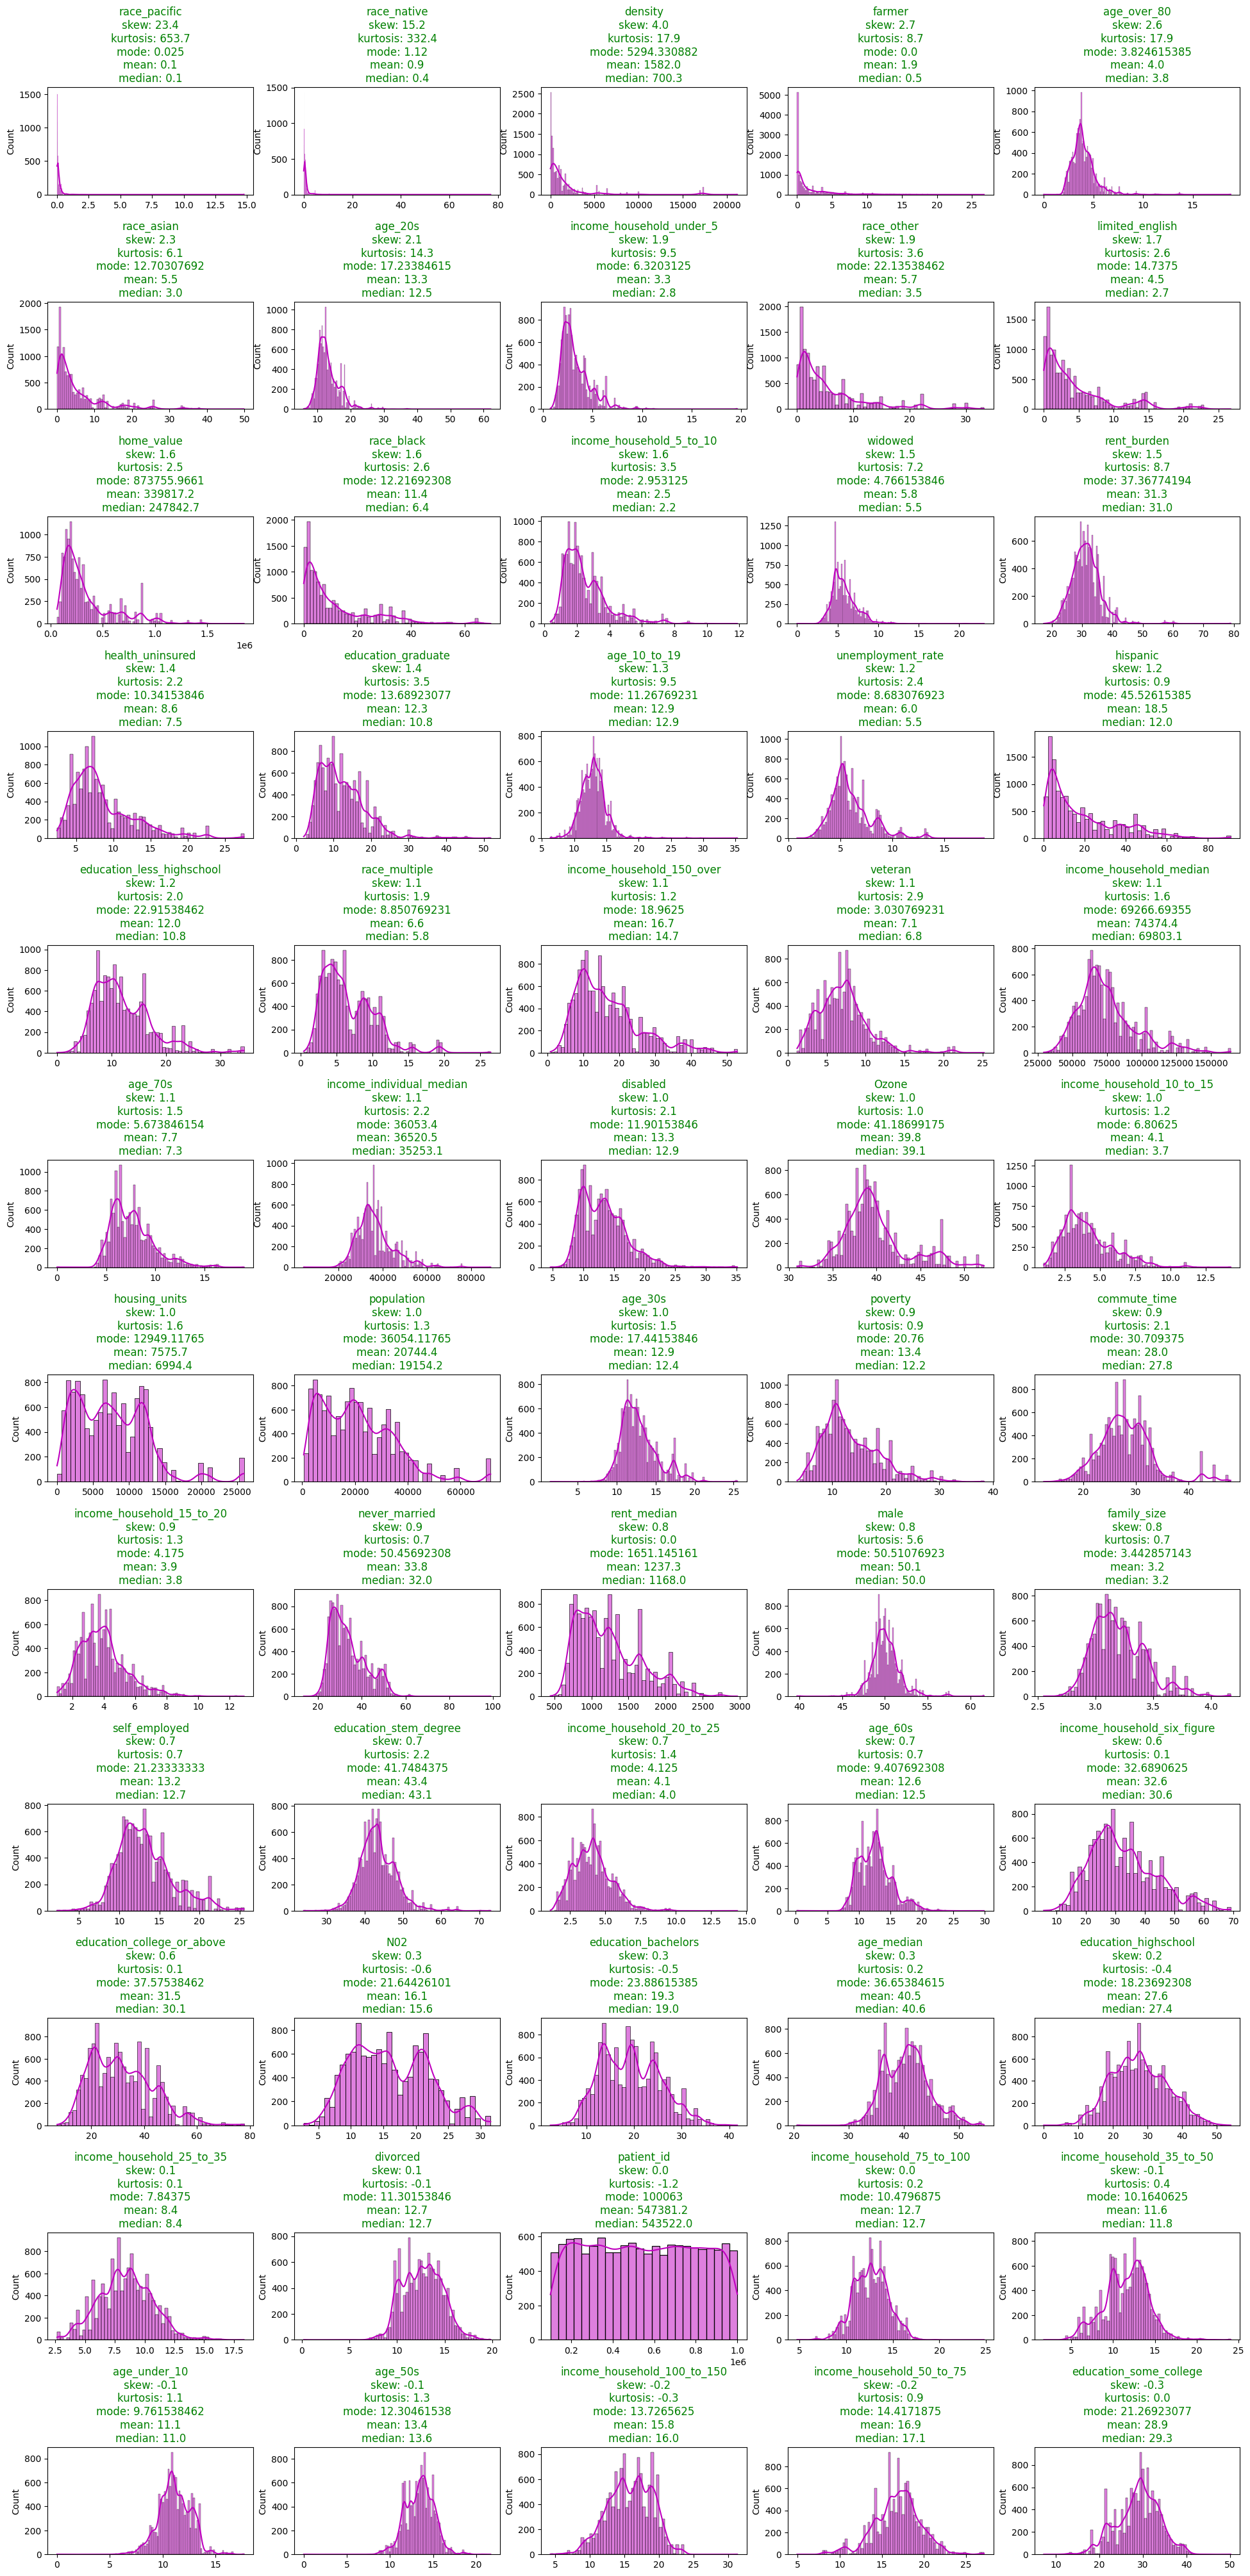

In [163]:
# list of columns ordered by skeweness
skew = X_Demographic.skew().sort_values(ascending=False).index.tolist()

plot_demographic_features(X_Demographic, skew[:60], 12, 5, (24, 50))


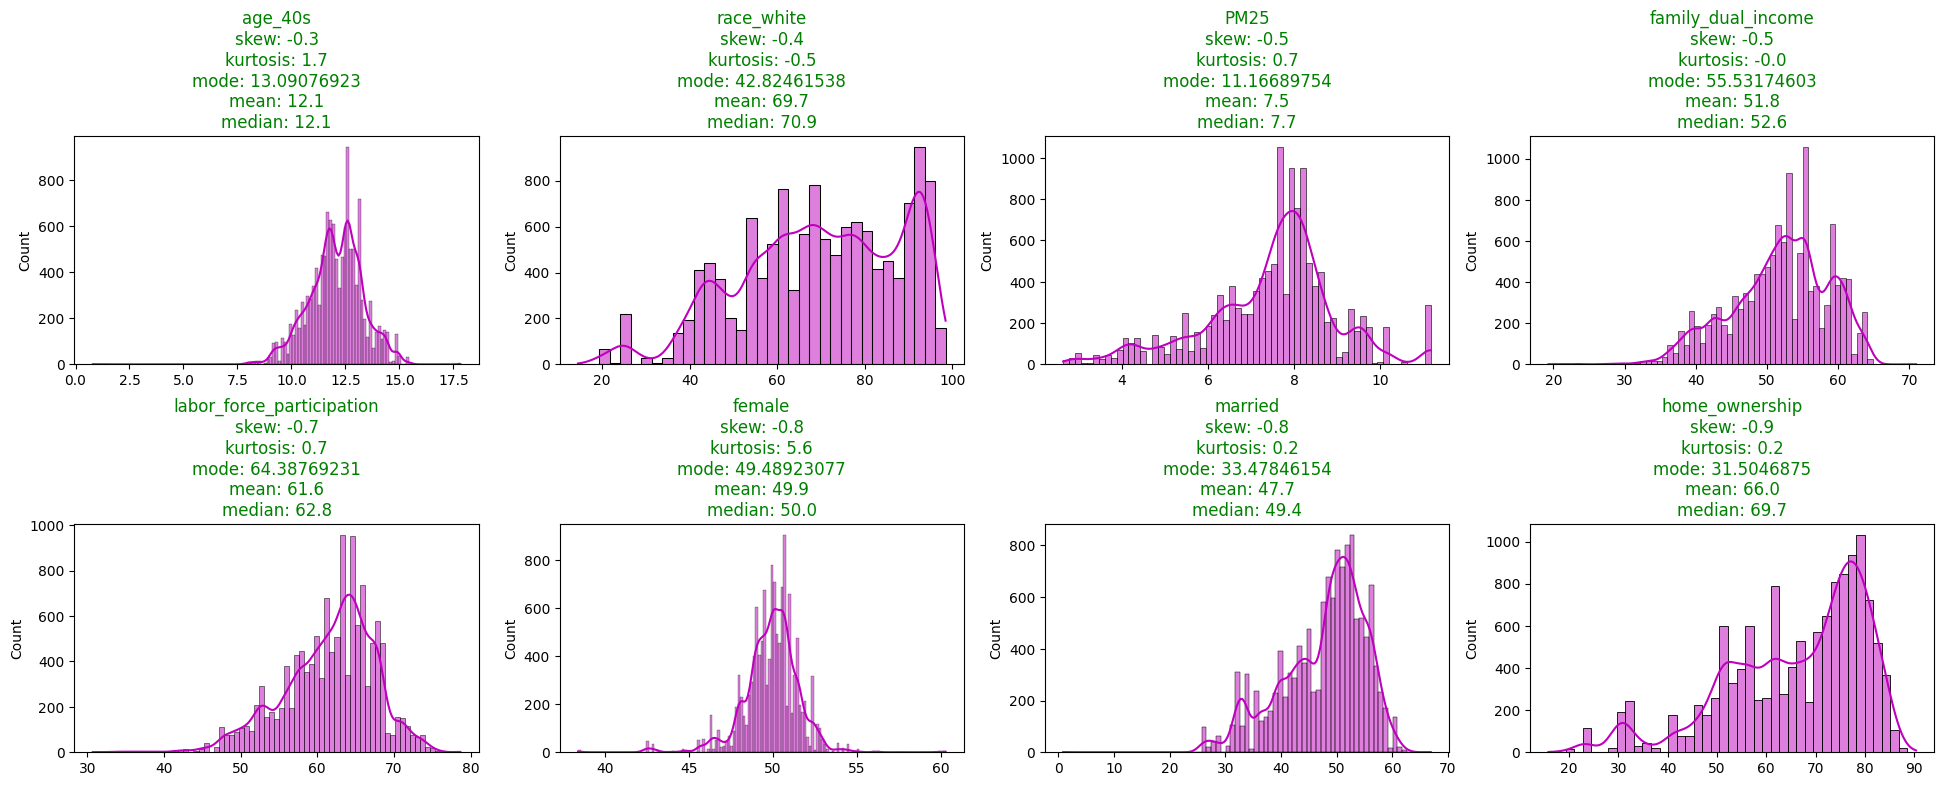

In [164]:
plot_demographic_features(X_Demographic, skew[60:], 2, 4, (24, 8), hspace=0.7)

In [178]:
def plot_demographic_target_relation(data_frame, obj, vec, rows, cols, figsize, hspace=1):
    _, axes = plt.subplots(rows, cols, figsize=figsize)
    plt.subplots_adjust(hspace=hspace)
    axes = axes.ravel()

    for i, col in enumerate(vec):
        sns.histplot(data=data_frame, x=col, hue=obj, ax=axes[i], kde=True)
        title = \
            f'{col}\n' \
            f'median t=0: {data_frame[data_frame[obj] == 0][col].median():.1f}\n' \
            f'median t=1: {data_frame[data_frame[obj] == 1][col].median():.1f}'
        axes[i].set_title(title, color='g')
        axes[i].set_xlabel('')

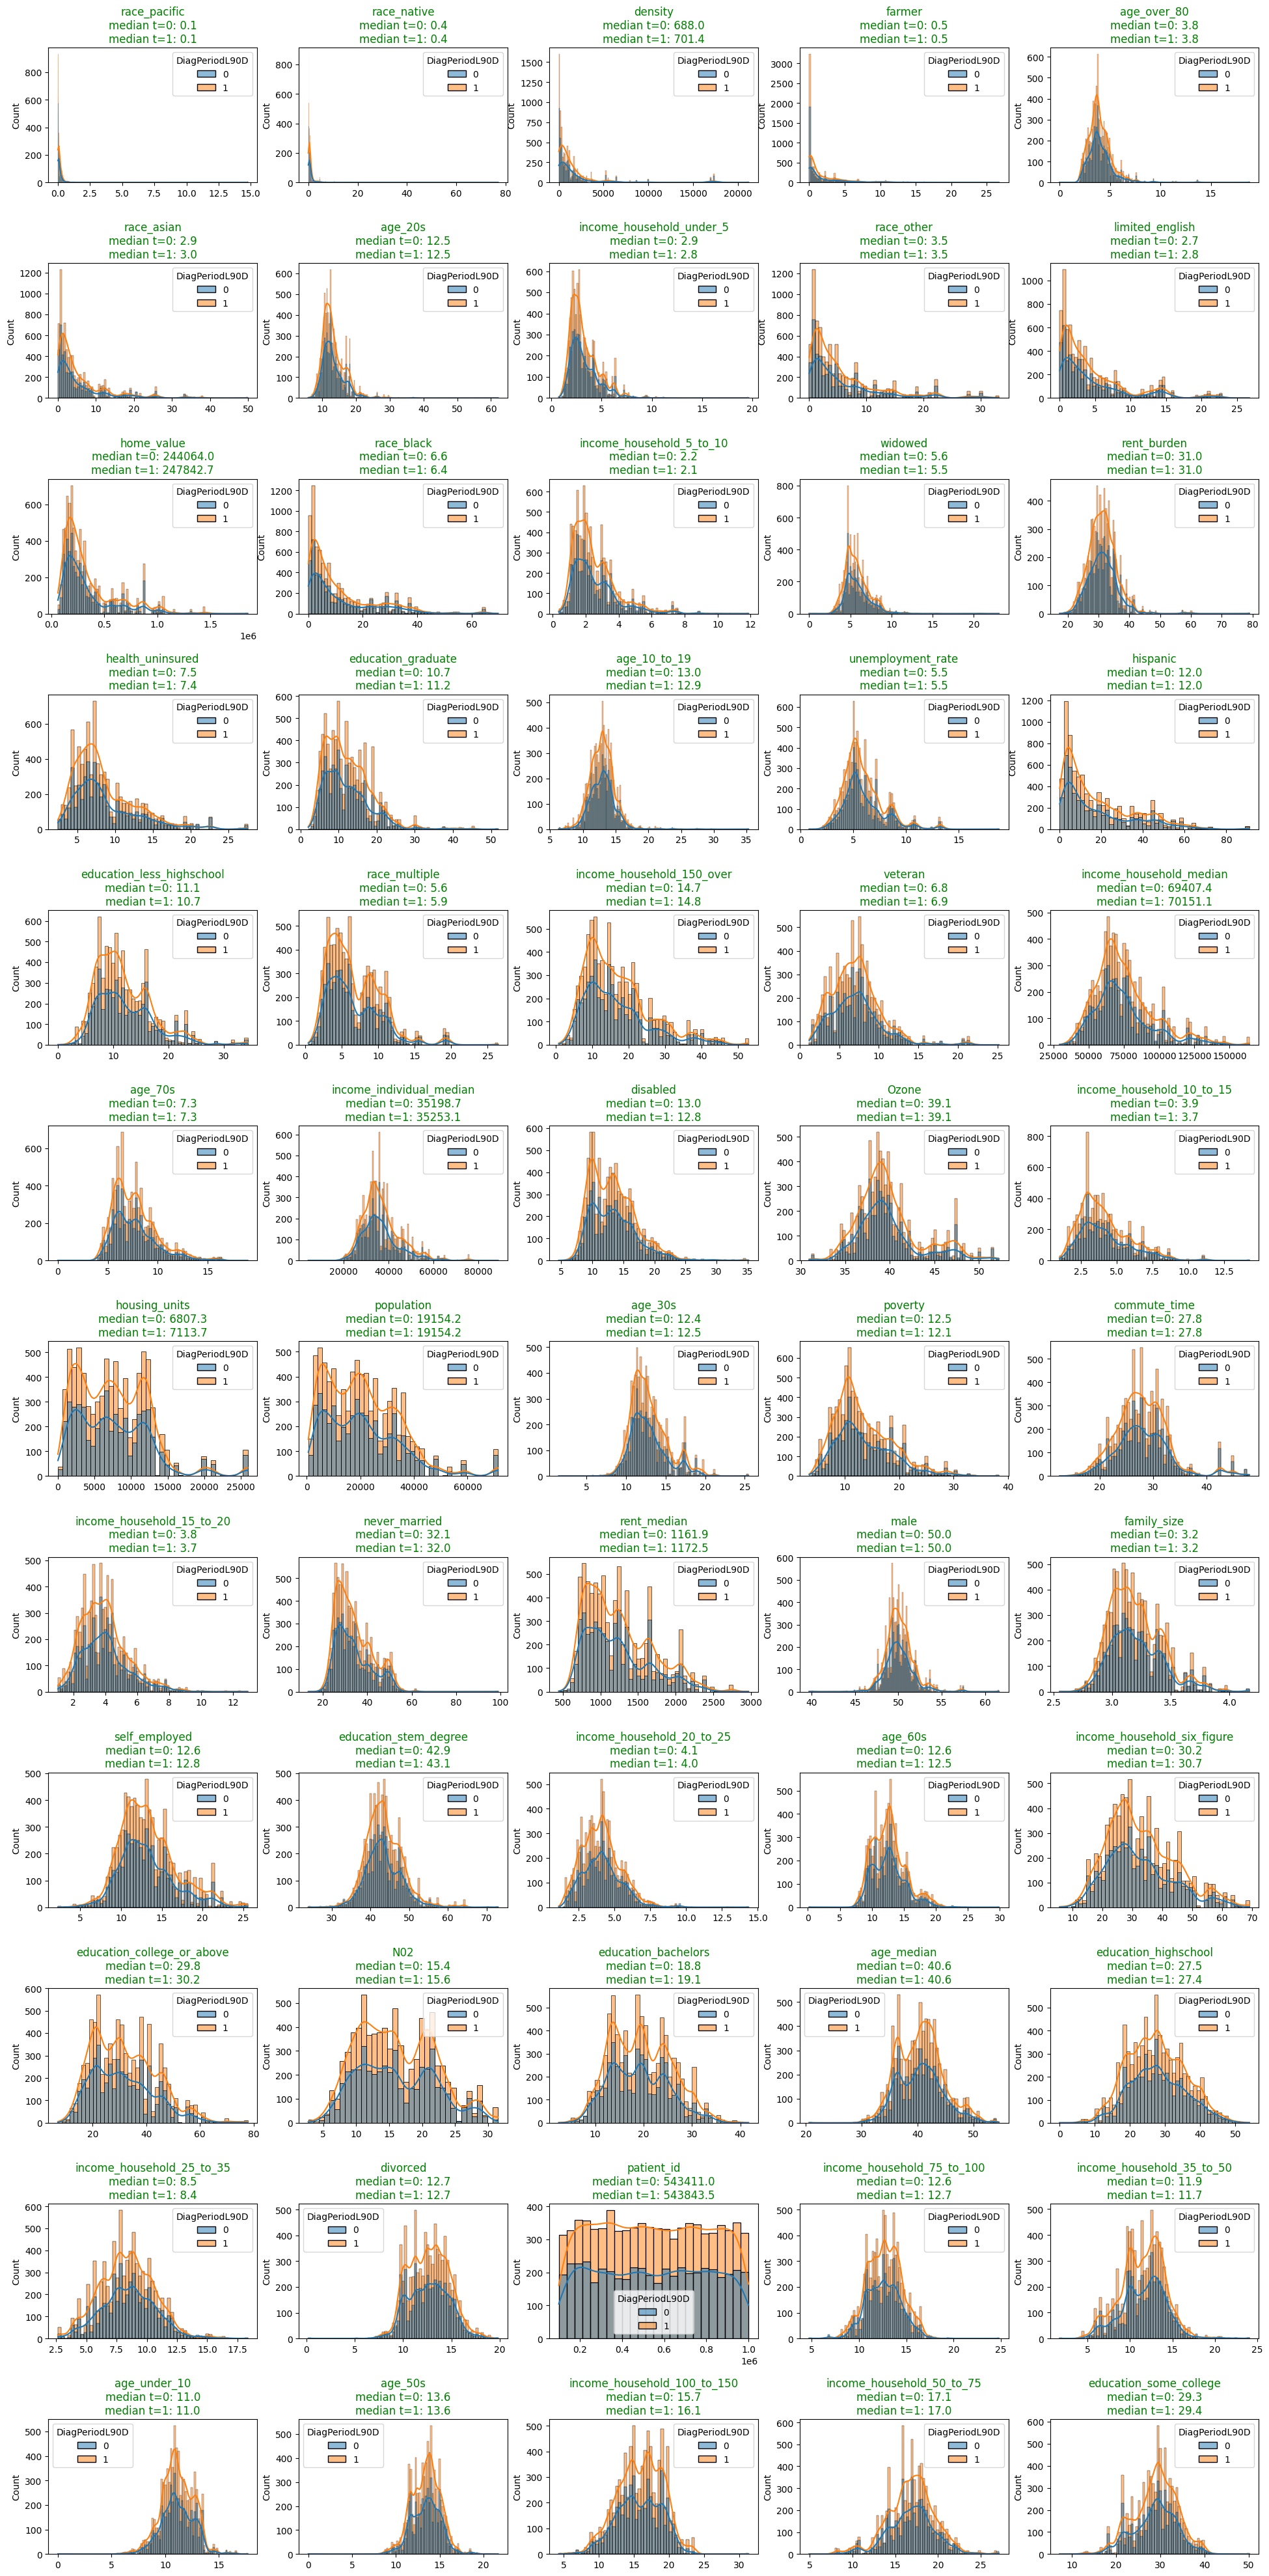

In [180]:
X_Demographic['DiagPeriodL90D'] = y

plot_demographic_target_relation(X_Demographic, 'DiagPeriodL90D', skew[:60], 12, 5, (24, 50), hspace=0.6)

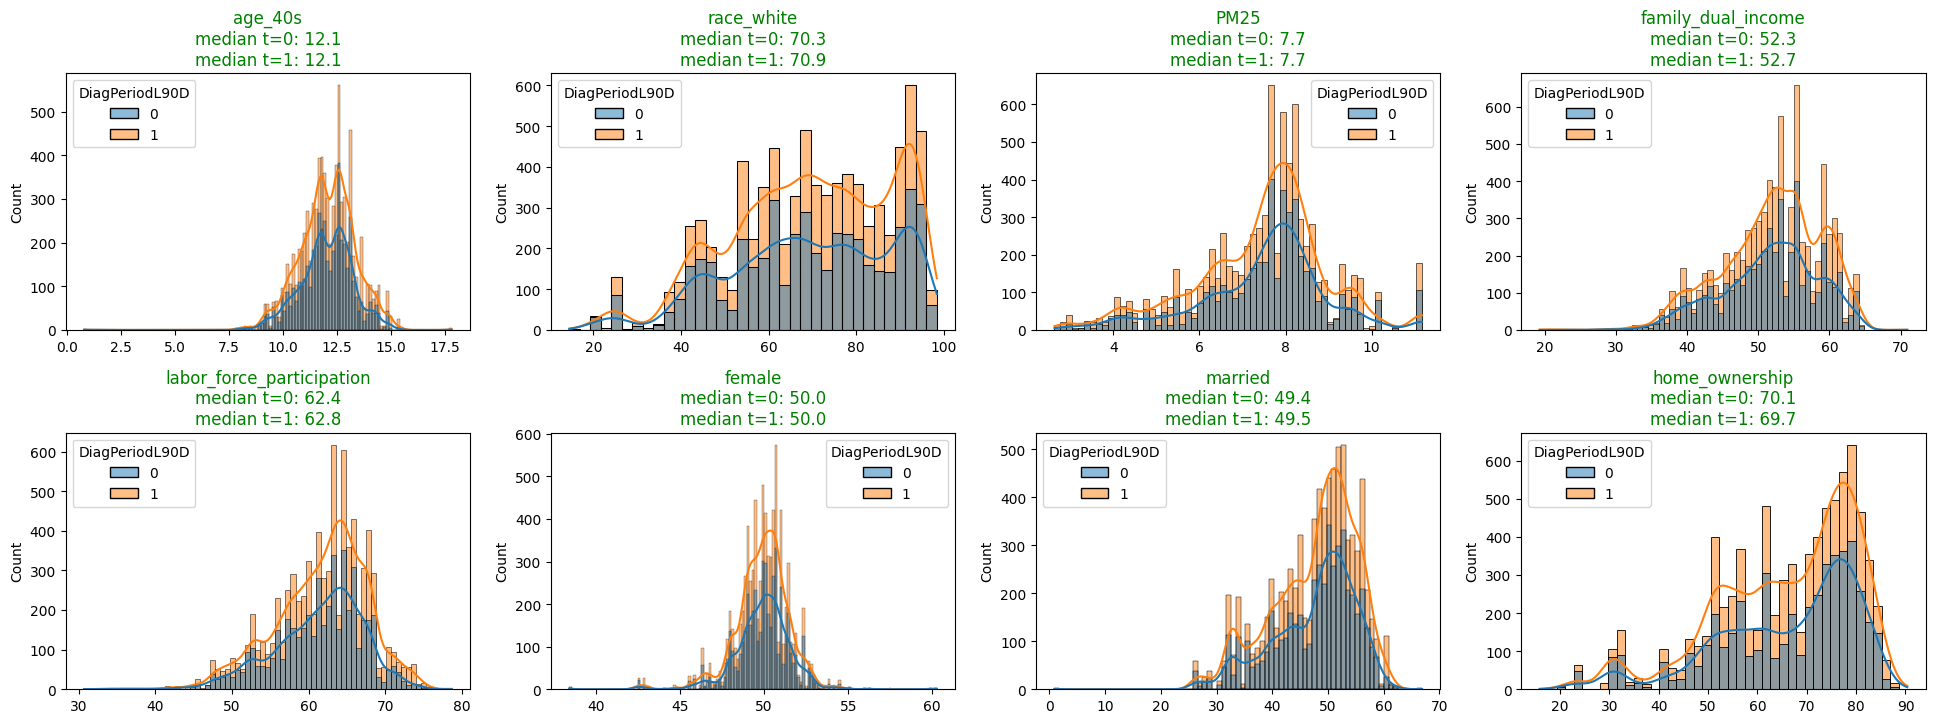

In [181]:
plot_demographic_target_relation(X_Demographic, 'DiagPeriodL90D', skew[60:], 2, 4, (24, 8), hspace=0.4)